In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing Libraries
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import plot_model, model_to_dot
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization

In [ ]:
keras.backend.set_image_data_format('channels_last')

In [ ]:
def evaluate(predicted_outcome, expected_outcome):
    from sklearn import metrics
    f1_score = metrics.f1_score(expected_outcome, predicted_outcome, average='weighted')
    balanced_accuracy_score = metrics.balanced_accuracy_score(expected_outcome, predicted_outcome)
    return f1_score, balanced_accuracy_score

In [ ]:
# Data Preprocessing
def load_dataset_with_processing(input_train_test_fn, num_classes=10):
    data = np.load(input_train_test_fn)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

    # split validation set
    from sklearn.model_selection import train_test_split
    X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

    X_train = np.array(X_train, dtype="float") / 255.0
    X_train = X_train.reshape(X_train.shape[0], 28, 28,1 )
    print(X_train.shape)

    X_vali = np.array(X_vali, dtype="float") / 255.0
    X_vali = X_vali.reshape(X_vali.shape[0], 28, 28,1 )
    print(X_vali.shape)

    X_test = np.array(X_test, dtype="float") / 255.0
    X_test = X_test.reshape(X_test.shape[0], 28, 28,1 )
    print(X_test.shape)

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_vali = keras.utils.to_categorical(y_vali, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return X_train, y_train, X_vali, y_vali, X_test, y_test

In [ ]:
# Creating a data generator for real-time data augmentation
def myGenerator(X_train, y_train, batch_size):
    total_size = X_train.shape[0]

    while True:
        permutation = list(np.random.permutation(total_size))
        for i in range(total_size//batch_size):
            index = permutation[i * batch_size : (i + 1) * batch_size]
            X_batch = X_train[index]
            y_batch = y_train[index]

            yield X_batch, y_batch

In [ ]:
# Define VGG16 Model
def build_model(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),

        # Block 2
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),

        # Block 3
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),

        # Block 4
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),

        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
    ])

    for layer in model.layers:
        layer.trainable = False  # freeze the previous layers

    X = model.output
    # softmax classifier
    predictions = Dense(10, activation='softmax')(X)
    old_model = Model(inputs=model.input, outputs=predictions)

    # load weights
    old_model.load_weights('/content/drive/MyDrive/pretrained_mnist/vgg.h5')

    X = model.output
    # softmax classifier
    predictions = Dense(num_classes, activation='softmax')(X)
    new_model = Model(inputs=model.input, outputs=predictions)

    new_model.summary()

    return new_model

input_shape = (28, 28, 1)
num_classes = 10
model = build_model(input_shape, num_classes)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       147584    
                                                           

In [ ]:
def train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs):
    import os
    if os.path.exists(checkpoint_dir) is False:
        os.makedirs(checkpoint_dir)

    model = build_model(input_shape, num_classes)

    checkpoint = ModelCheckpoint(checkpoint_dir + 'best_vgg16.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    datagen = myGenerator(X_train, y_train, batch_size)

    history = model.fit(datagen,
                        steps_per_epoch = len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[es, checkpoint],
                        verbose=2,
                        validation_data=(X_vali, y_vali))

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

    return model

In [ ]:
def test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights):
    model = build_model(input_shape, num_classes)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    # load weights
    model.load_weights(pretrained_weights)

    score = model.evaluate(X_test, y_test, verbose=0)

    testPredict = model.predict(X_test)
    y_test_tmp = np.argmax(y_test, axis=1)
    y_pred_tmp = np.argmax(testPredict, axis=1)
    f1_score, balanced_accuracy_score = evaluate(y_pred_tmp, y_test_tmp)

    return score[1], f1_score, balanced_accuracy_score  # return accuracies

Training VGG16 on individual datasets


(5280, 28, 28, 1)
(1320, 28, 28, 1)
(1000, 28, 28, 1)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 - 7s - loss: 0.6159 - accuracy: 0.8630 - val_loss: 0.3680 - val_accuracy: 0.8932 - 7s/epoch - 161ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.89318
41/41 - 1s - loss: 0.3194 - accuracy: 0.9051 - val_loss: 0.3444 - val_accuracy: 0.8909 - 761ms/epoch - 19ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.89318 to 0.90682, saving model to ./ADRIS_VGG16_MNIST_MIX/best_vgg16.hdf5
41/41 - 1s - loss: 0.3112 - accuracy: 0.9103 - val_loss: 0.3124 - val_accuracy: 0.9068 - 1s/epoch - 27ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.90682
41/41 - 1s - loss: 0.2858 - accuracy: 0.9127 - val_loss: 0.3253 - val_accuracy: 0.9068 - 973ms/epoch - 24ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.90682 to 0.90909, saving model to ./ADRIS_VGG16_MNIST_MIX/best_vgg16.hdf5
41/41 - 2s - loss: 0.2698 - accuracy: 0.9154 - val_loss: 0.3097 - val_accuracy: 0.9091 - 2s/epoch - 55ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.90909
41/41 

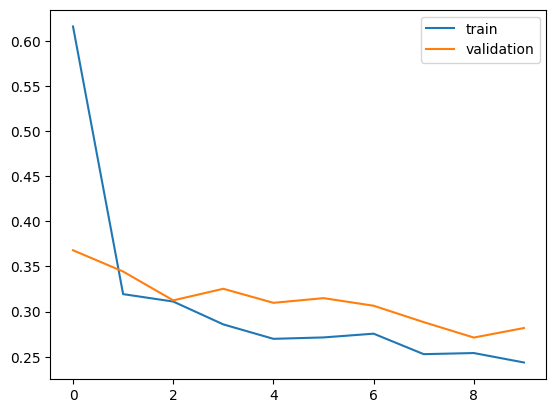

In [ ]:
# Training on ARDIS Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ADRIS_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/ARDIS_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on ADRIS test data
pretrained_weights = '/content/ADRIS_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 14, 14, 128)       1475

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 - 2s - loss: 2.1512 - accuracy: 0.3526 - val_loss: 1.4727 - val_accuracy: 0.4521 - 2s/epoch - 124ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.45208 to 0.49792, saving model to ./ARABIC_VGG16_MNIST_MIX/best_vgg16.hdf5
15/15 - 1s - loss: 1.3640 - accuracy: 0.4521 - val_loss: 1.2974 - val_accuracy: 0.4979 - 690ms/epoch - 46ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.49792 to 0.52708, saving model to ./ARABIC_VGG16_MNIST_MIX/best_vgg16.hdf5
15/15 - 1s - loss: 1.2683 - accuracy: 0.4885 - val_loss: 1.2434 - val_accuracy: 0.5271 - 564ms/epoch - 38ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.52708
15/15 - 0s - loss: 1.2011 - accuracy: 0.5276 - val_loss: 1.2597 - val_accuracy: 0.4979 - 291ms/epoch - 19ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.52708
15/15 - 0s - loss: 1.2245 - accuracy: 0.5302 - val_loss: 1.2309 - val_accuracy: 0.5250 - 357ms/epoch - 24ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.52708 to 0.

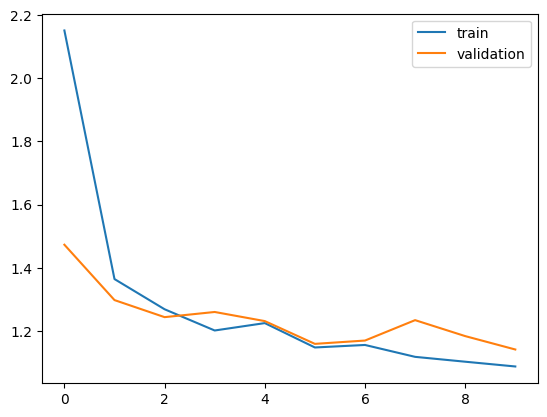

In [ ]:
# Training on CMATTERDB 3.3.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ARABIC_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Arabic_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTER 3.3.1 test data
pretrained_weights = '/content/ARABIC_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_43 (Conv2D)          (None, 14, 14, 128)       1475

(12638, 28, 28, 1)
(3160, 28, 28, 1)
(3950, 28, 28, 1)
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_50 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_51 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 co

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 3s - loss: 1.2438 - accuracy: 0.5960 - val_loss: 1.0469 - val_accuracy: 0.6364 - 3s/epoch - 33ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.63639
98/98 - 2s - loss: 1.0163 - accuracy: 0.6507 - val_loss: 1.0578 - val_accuracy: 0.6332 - 2s/epoch - 18ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.63639
98/98 - 2s - loss: 0.9920 - accuracy: 0.6566 - val_loss: 1.0472 - val_accuracy: 0.6263 - 2s/epoch - 18ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.63639 to 0.64462, saving model to ./BANGLALEKHA_VGG16_MNIST_MIX/best_vgg16.hdf5
98/98 - 2s - loss: 0.9655 - accuracy: 0.6641 - val_loss: 1.0260 - val_accuracy: 0.6446 - 2s/epoch - 21ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.64462
98/98 - 3s - loss: 0.9652 - accuracy: 0.6699 - val_loss: 1.0371 - val_accuracy: 0.6345 - 3s/epoch - 26ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.64462 to 0.65601, saving model to ./BANGLALEKHA_VGG16_MNIST_MIX/best_vgg16.hdf5
9

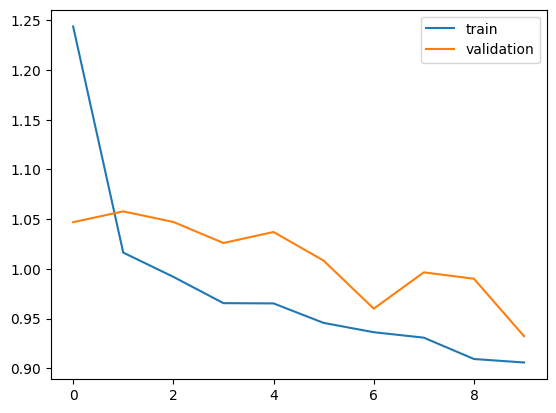

In [ ]:
# Training on BanglaLekha Isolated Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './BANGLALEKHA_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/BanglaLekha_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on BanglaLekha Isolated test data
pretrained_weights = '/content/BANGLALEKHA_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_60 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_61 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_63 (Conv2D)          (None, 14, 14, 128)       147

(3840, 28, 28, 1)
(960, 28, 28, 1)
(1200, 28, 28, 1)
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_70 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_71 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 - 2s - loss: 1.4519 - accuracy: 0.5763 - val_loss: 1.0830 - val_accuracy: 0.6271 - 2s/epoch - 64ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.62708 to 0.65312, saving model to ./BANGLA_VGG16_MNIST_MIX/best_vgg16.hdf5
30/30 - 1s - loss: 0.9612 - accuracy: 0.6596 - val_loss: 1.0149 - val_accuracy: 0.6531 - 874ms/epoch - 29ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.65312
30/30 - 1s - loss: 0.9179 - accuracy: 0.6706 - val_loss: 1.0307 - val_accuracy: 0.6281 - 578ms/epoch - 19ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.65312
30/30 - 1s - loss: 0.8804 - accuracy: 0.6906 - val_loss: 1.0148 - val_accuracy: 0.6458 - 711ms/epoch - 24ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.65312
30/30 - 1s - loss: 0.8737 - accuracy: 0.6891 - val_loss: 0.9985 - val_accuracy: 0.6500 - 635ms/epoch - 21ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.65312 to 0.66875, saving model to ./BANGLA_VGG16_MNIST_MIX/best_vgg16.hdf5

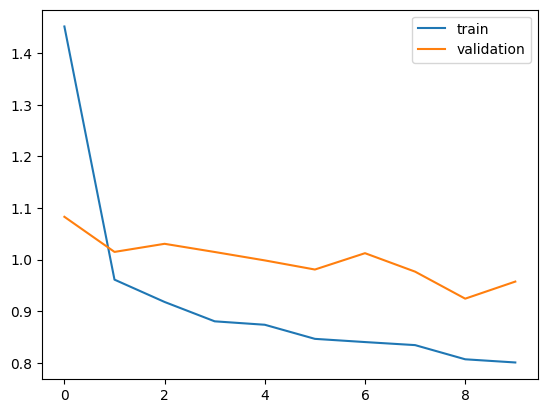

In [ ]:
# Training on CMATTERDB 3.1.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './BANGLA_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Bangla_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.1.1 test data
pretrained_weights = '/content/BANGLA_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_80 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_81 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_82 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_83 (Conv2D)          (None, 14, 14, 128)       147

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_90 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_91 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_92 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 - 2s - loss: 1.7988 - accuracy: 0.5745 - val_loss: 1.2570 - val_accuracy: 0.6229 - 2s/epoch - 113ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.62292 to 0.63958, saving model to ./DEVANAGARI_VGG16_MNIST_MIX/best_vgg16.hdf5
15/15 - 1s - loss: 1.0109 - accuracy: 0.6656 - val_loss: 1.0356 - val_accuracy: 0.6396 - 711ms/epoch - 47ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.63958 to 0.65625, saving model to ./DEVANAGARI_VGG16_MNIST_MIX/best_vgg16.hdf5
15/15 - 1s - loss: 0.9111 - accuracy: 0.6932 - val_loss: 1.0324 - val_accuracy: 0.6562 - 593ms/epoch - 40ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.65625
15/15 - 0s - loss: 0.8942 - accuracy: 0.7010 - val_loss: 1.0223 - val_accuracy: 0.6542 - 290ms/epoch - 19ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.65625 to 0.66667, saving model to ./DEVANAGARI_VGG16_MNIST_MIX/best_vgg16.hdf5
15/15 - 1s - loss: 0.8708 - accuracy: 0.7089 - val_loss: 0.9895 - val_accuracy: 0.6667 - 744ms/epoch

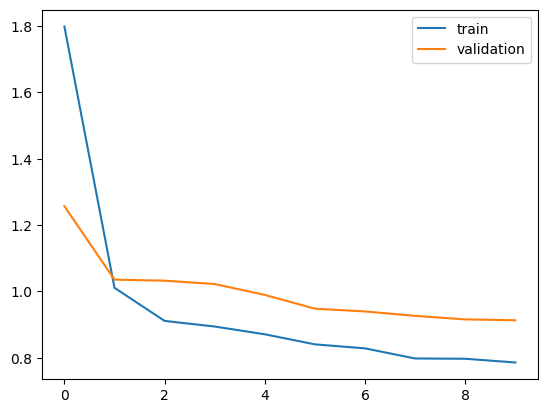

In [ ]:
# Training on CMATTERDB 3.2.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './DEVANAGARI_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Devanagari_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.2.1 test data
pretrained_weights = '/content/DEVANAGARI_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_100 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_101 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_102 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_103 (Conv2D)         (None, 14, 14, 128)       147

(192000, 28, 28, 1)
(48000, 28, 28, 1)
(40000, 28, 28, 1)
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_110 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_111 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_112 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 - 29s - loss: 0.0958 - accuracy: 0.9808 - val_loss: 0.0874 - val_accuracy: 0.9817 - 29s/epoch - 20ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.98169 to 0.98254, saving model to ./EMNIST_VGG16_MNIST_MIX/best_vgg16.hdf5
1500/1500 - 30s - loss: 0.0840 - accuracy: 0.9829 - val_loss: 0.0929 - val_accuracy: 0.9825 - 30s/epoch - 20ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.98254 to 0.98408, saving model to ./EMNIST_VGG16_MNIST_MIX/best_vgg16.hdf5
1500/1500 - 30s - loss: 0.0811 - accuracy: 0.9834 - val_loss: 0.0748 - val_accuracy: 0.9841 - 30s/epoch - 20ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.98408 to 0.98462, saving model to ./EMNIST_VGG16_MNIST_MIX/best_vgg16.hdf5
1500/1500 - 30s - loss: 0.0788 - accuracy: 0.9839 - val_loss: 0.0823 - val_accuracy: 0.9846 - 30s/epoch - 20ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.98462 to 0.98494, saving model to ./EMNIST_VGG16_MNIST_MIX/best_vgg16.hdf5
1500/1500 - 30s - loss: 0.0786 - acc

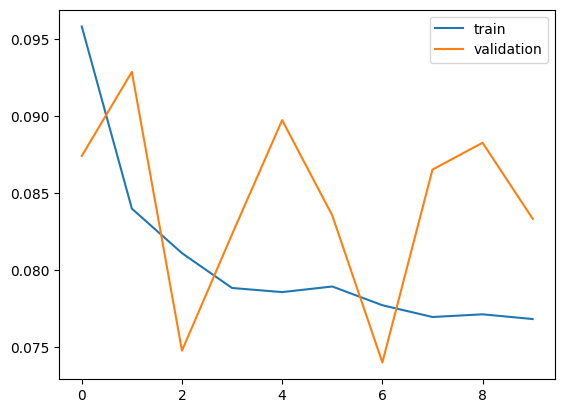

In [ ]:
# Training on EMNIST Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './EMNIST_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/EMNIST_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on EMNIST test data
pretrained_weights = '/content/EMNIST_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_120 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_121 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_122 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_123 (Conv2D)         (None, 14, 14, 128)       147

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(20000, 28, 28, 1)
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_130 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_131 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_132 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 - 9s - loss: 1.0207 - accuracy: 0.6078 - val_loss: 0.9320 - val_accuracy: 0.6292 - 9s/epoch - 24ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.62917 to 0.67283, saving model to ./FARSI_VGG16_MNIST_MIX/best_vgg16.hdf5
375/375 - 8s - loss: 0.8945 - accuracy: 0.6522 - val_loss: 0.8602 - val_accuracy: 0.6728 - 8s/epoch - 21ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.67283
375/375 - 8s - loss: 0.8616 - accuracy: 0.6632 - val_loss: 0.8445 - val_accuracy: 0.6686 - 8s/epoch - 20ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.67283 to 0.68825, saving model to ./FARSI_VGG16_MNIST_MIX/best_vgg16.hdf5
375/375 - 7s - loss: 0.8455 - accuracy: 0.6724 - val_loss: 0.8132 - val_accuracy: 0.6883 - 7s/epoch - 19ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.68825 to 0.68967, saving model to ./FARSI_VGG16_MNIST_MIX/best_vgg16.hdf5
375/375 - 8s - loss: 0.8213 - accuracy: 0.6797 - val_loss: 0.8023 - val_accuracy: 0.6897 - 8s/epoch - 21ms/step
Epoch

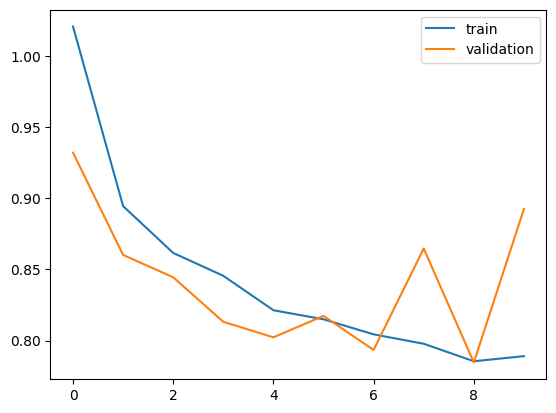

In [ ]:
# Training on FARSI Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './FARSI_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Farsi_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on FARSI test data
pretrained_weights = '/content/FARSI_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_140_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_140 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_141 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_142 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_143 (Conv2D)         (None, 14, 14, 128)       147

(15513, 28, 28, 1)
(3879, 28, 28, 1)
(4000, 28, 28, 1)
Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_150_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_150 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_151 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_152 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 co

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 - 4s - loss: 1.0946 - accuracy: 0.6301 - val_loss: 0.9717 - val_accuracy: 0.6618 - 4s/epoch - 36ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.66177 to 0.68059, saving model to ./ISIBANGLA_VGG16_MNIST_MIX/best_vgg16.hdf5
121/121 - 3s - loss: 0.8990 - accuracy: 0.6792 - val_loss: 0.8863 - val_accuracy: 0.6806 - 3s/epoch - 27ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.68059 to 0.68626, saving model to ./ISIBANGLA_VGG16_MNIST_MIX/best_vgg16.hdf5
121/121 - 3s - loss: 0.8553 - accuracy: 0.6946 - val_loss: 0.9171 - val_accuracy: 0.6863 - 3s/epoch - 22ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.68626 to 0.70327, saving model to ./ISIBANGLA_VGG16_MNIST_MIX/best_vgg16.hdf5
121/121 - 3s - loss: 0.8313 - accuracy: 0.7007 - val_loss: 0.8633 - val_accuracy: 0.7033 - 3s/epoch - 27ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.70327 to 0.70972, saving model to ./ISIBANGLA_VGG16_MNIST_MIX/best_vgg16.hdf5
121/121 - 3s - loss: 0.8210 - accuracy: 

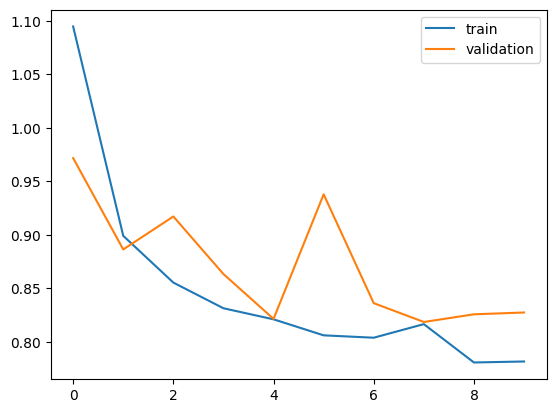

In [ ]:
# Training on ISI BANGLA Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ISIBANGLA_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/ISI_Bangla_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on ISI BANGLA test data
pretrained_weights = '/content/ISIBANGLA_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_160_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_160 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_161 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_64 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_162 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_163 (Conv2D)         (None, 14, 14, 128)       147

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(20240, 28, 28, 1)
Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_170_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_170 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_171 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_172 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 - 9s - loss: 0.8269 - accuracy: 0.7174 - val_loss: 0.7032 - val_accuracy: 0.7558 - 9s/epoch - 24ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.75575 to 0.77917, saving model to ./KANNADA_VGG16_MNIST_MIX/best_vgg16.hdf5
375/375 - 8s - loss: 0.6803 - accuracy: 0.7605 - val_loss: 0.6437 - val_accuracy: 0.7792 - 8s/epoch - 20ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.77917
375/375 - 7s - loss: 0.6451 - accuracy: 0.7753 - val_loss: 0.6711 - val_accuracy: 0.7742 - 7s/epoch - 19ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.77917
375/375 - 7s - loss: 0.6297 - accuracy: 0.7794 - val_loss: 0.6789 - val_accuracy: 0.7582 - 7s/epoch - 20ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.77917 to 0.78192, saving model to ./KANNADA_VGG16_MNIST_MIX/best_vgg16.hdf5
375/375 - 8s - loss: 0.6084 - accuracy: 0.7862 - val_loss: 0.6183 - val_accuracy: 0.7819 - 8s/epoch - 21ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.78192

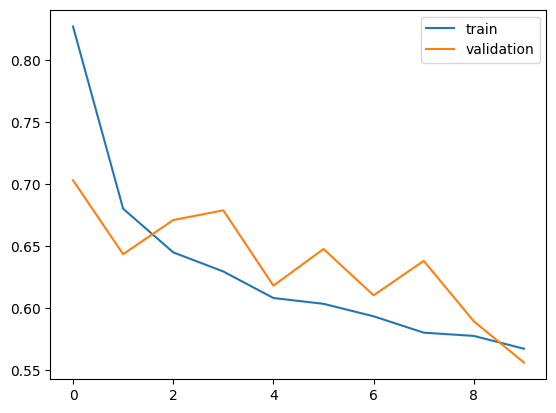

In [ ]:
# Training on Kannada Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './KANNADA_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Kannada_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on kannada test data
pretrained_weights = '/content/KANNADA_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_180_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_180 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_181 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_182 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_183 (Conv2D)         (None, 14, 14, 128)       147

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_190_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_190 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_191 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_76 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_192 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 - 9s - loss: 0.6425 - accuracy: 0.7980 - val_loss: 0.5423 - val_accuracy: 0.8238 - 9s/epoch - 24ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.82383
375/375 - 7s - loss: 0.5339 - accuracy: 0.8256 - val_loss: 0.5328 - val_accuracy: 0.8186 - 7s/epoch - 19ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.82383 to 0.83892, saving model to ./MADBASE_VGG16_MNIST_MIX/best_vgg16.hdf5
375/375 - 8s - loss: 0.5060 - accuracy: 0.8327 - val_loss: 0.4776 - val_accuracy: 0.8389 - 8s/epoch - 20ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.83892 to 0.84575, saving model to ./MADBASE_VGG16_MNIST_MIX/best_vgg16.hdf5
375/375 - 8s - loss: 0.4980 - accuracy: 0.8356 - val_loss: 0.4766 - val_accuracy: 0.8457 - 8s/epoch - 21ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.84575
375/375 - 8s - loss: 0.4836 - accuracy: 0.8401 - val_loss: 0.4685 - val_accuracy: 0.8426 - 8s/epoch - 21ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.84575 to 0.8

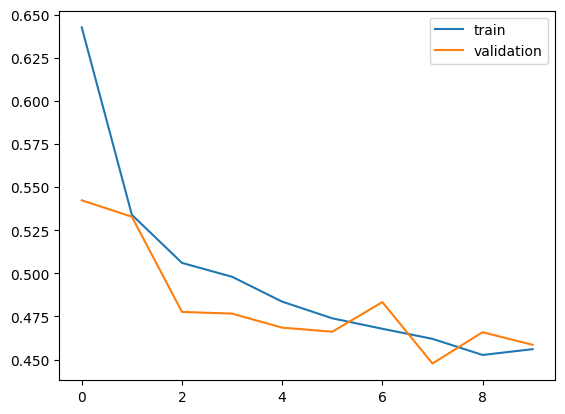

In [ ]:
# Training on MADBASE Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './MADBASE_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/MADBase_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on MADBASE test data
pretrained_weights = '/content/MADBASE_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_200_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_200 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_201 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_80 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_202 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_203 (Conv2D)         (None, 14, 14, 128)       147

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_210_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_210 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_211 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_84 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_212 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 - 2s - loss: 2.1678 - accuracy: 0.4167 - val_loss: 1.5486 - val_accuracy: 0.4458 - 2s/epoch - 149ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.44583 to 0.48542, saving model to ./TELUGU_VGG16_MNIST_MIX/best_vgg16.hdf5
15/15 - 1s - loss: 1.3590 - accuracy: 0.5208 - val_loss: 1.4790 - val_accuracy: 0.4854 - 698ms/epoch - 47ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.48542 to 0.48750, saving model to ./TELUGU_VGG16_MNIST_MIX/best_vgg16.hdf5
15/15 - 4s - loss: 1.2560 - accuracy: 0.5682 - val_loss: 1.4390 - val_accuracy: 0.4875 - 4s/epoch - 241ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.48750 to 0.51875, saving model to ./TELUGU_VGG16_MNIST_MIX/best_vgg16.hdf5
15/15 - 1s - loss: 1.2126 - accuracy: 0.5635 - val_loss: 1.3979 - val_accuracy: 0.5188 - 1s/epoch - 76ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.51875
15/15 - 0s - loss: 1.1745 - accuracy: 0.5786 - val_loss: 1.3805 - val_accuracy: 0.5083 - 357ms/epoch - 24ms/step
Epoc

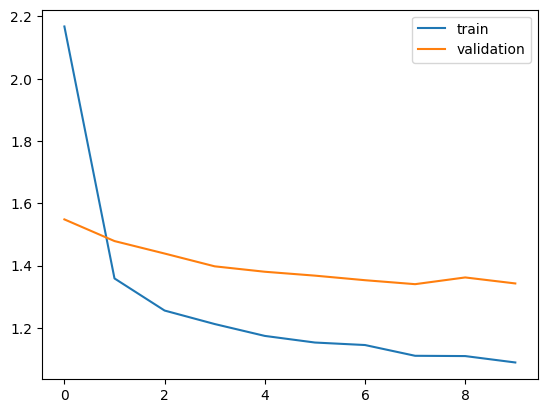

In [ ]:
# Training on CMATTERDB 3.4.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './TELUGU_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Telugu_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.4.1 test data
pretrained_weights = '/content/TELUGU_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_220_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_220 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_221 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_88 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_222 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_223 (Conv2D)         (None, 14, 14, 128)       147

(11371, 28, 28, 1)
(2843, 28, 28, 1)
(3554, 28, 28, 1)
Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_250_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_250 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_251 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_100 (MaxPool  (None, 14, 14, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_252 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 co

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 - 4s - loss: 1.1348 - accuracy: 0.6477 - val_loss: 0.9807 - val_accuracy: 0.6775 - 4s/epoch - 45ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.67745 to 0.69363, saving model to ./TIBETAN_VGG16_MNIST_MIX/best_vgg16.hdf5
88/88 - 2s - loss: 0.8949 - accuracy: 0.7045 - val_loss: 0.9079 - val_accuracy: 0.6936 - 2s/epoch - 24ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.69363 to 0.71087, saving model to ./TIBETAN_VGG16_MNIST_MIX/best_vgg16.hdf5
88/88 - 3s - loss: 0.8479 - accuracy: 0.7223 - val_loss: 0.8757 - val_accuracy: 0.7109 - 3s/epoch - 29ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.71087 to 0.72283, saving model to ./TIBETAN_VGG16_MNIST_MIX/best_vgg16.hdf5
88/88 - 2s - loss: 0.8093 - accuracy: 0.7331 - val_loss: 0.8421 - val_accuracy: 0.7228 - 2s/epoch - 23ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.72283 to 0.72353, saving model to ./TIBETAN_VGG16_MNIST_MIX/best_vgg16.hdf5
88/88 - 2s - loss: 0.8027 - accuracy: 0.7340 - val_loss:

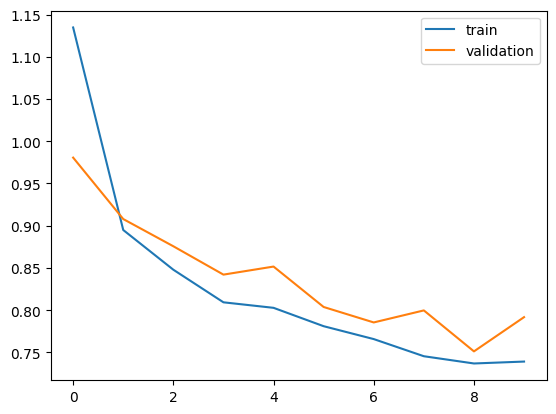

In [ ]:
# Training on Tibetan Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './TIBETAN_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Tibetan_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on TIBETAN test data
pretrained_weights = '/content/TIBETAN_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_260_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_260 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_261 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_104 (MaxPool  (None, 14, 14, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_262 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_263 (Conv2D)         (None, 14, 14, 128)       147

(5284, 28, 28, 1)
(1322, 28, 28, 1)
(1414, 28, 28, 1)
Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_270_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_270 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_271 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_108 (MaxPool  (None, 14, 14, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_272 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 con

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 - 3s - loss: 1.5389 - accuracy: 0.4907 - val_loss: 1.1753 - val_accuracy: 0.5794 - 3s/epoch - 65ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.57943 to 0.61876, saving model to ./URDU_VGG16_MNIST_MIX/best_vgg16.hdf5
41/41 - 1s - loss: 1.0875 - accuracy: 0.6099 - val_loss: 1.0848 - val_accuracy: 0.6188 - 1s/epoch - 27ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.61876 to 0.64221, saving model to ./URDU_VGG16_MNIST_MIX/best_vgg16.hdf5
41/41 - 1s - loss: 1.0180 - accuracy: 0.6258 - val_loss: 1.0670 - val_accuracy: 0.6422 - 1s/epoch - 28ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.64221
41/41 - 1s - loss: 0.9924 - accuracy: 0.6433 - val_loss: 1.0583 - val_accuracy: 0.6225 - 787ms/epoch - 19ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.64221
41/41 - 1s - loss: 0.9797 - accuracy: 0.6473 - val_loss: 1.0165 - val_accuracy: 0.6392 - 836ms/epoch - 20ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.64221 to 0.65431, savi

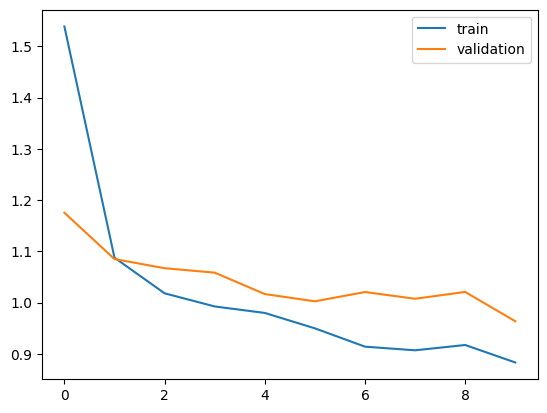

In [ ]:
# Training on URDU Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './URDU_VGG16_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Urdu_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on URDU test data
pretrained_weights = '/content/URDU_VGG16_MNIST_MIX/best_vgg16.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_280_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_280 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_281 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_112 (MaxPool  (None, 14, 14, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_282 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_283 (Conv2D)         (None, 14, 14, 128)       147